# Business Understanding


Since 2008, guests and hosts have used **Airbnb**  to travel in a more unique, personalized way. As part of the Airbnb Inside initiative, this dataset describes **the listing activity of homestays in Seattle, WA.**


The following Airbnb activity is included in this Seattle dataset:

* **Listings**, including full descriptions and average review score
* **Reviews**, including unique id for each reviewer and detailed comments
* **Calendar**, including listing id and the price and availability for that day


In This Project, we need to answer 4 questions: 
1. what is the busiest month in terms of availbility of listings ? 
2. when is the highest aver price of listings per night ? 
3. Where are the most expensive listings ? at which neighbourhoods in Seattle
4. Who are the top host names and what are the types of listings they offer ?

In Order to answer these questions , we will use 
* Calendar.csv 
* listings.csv


# Data Understanding

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import math
pd.set_option('max_columns', None)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/seattle/calendar.csv
/kaggle/input/seattle/listings.csv
/kaggle/input/seattle/reviews.csv


Importing datasets

In [2]:
df_calendar=pd.read_csv('/kaggle/input/seattle/calendar.csv')
df_listing=pd.read_csv('/kaggle/input/seattle/listings.csv')
df_reviews=pd.read_csv('/kaggle/input/seattle/reviews.csv')

In [3]:
#understanding df_calendar 
df_calendar.head()


,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [4]:
print("Number of rows is {} and number of columns is {}".format(df_calendar.shape[0],df_calendar.shape[1]))


Number of rows is 1393570 and number of columns is 4


In [5]:
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


**Price data type needs to be changed from string to float
and also remove $ from it**

In [6]:
#Understanding listings
df_calendar.head()


,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [7]:
print("Number of rows is {} and number of columns is {}".format(df_listing.shape[0],df_listing.shape[1]))


Number of rows is 3818 and number of columns is 92


In [8]:
df_listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

**Same price Issue that was in Calendar df , we need to convert it float and remove $ or , characters from it**


# Prepare Data 

Handling df_calendar

In [9]:
# removing $ and , if existed and convert the price to integar 


df_calendar['price']=df_calendar['price'].map(lambda v: float(v[1:].replace(",","")) if type(v) != float else v)
df_calendar['available'].replace({'t':1,'f':0},inplace=True)
df_calendar['month']=pd.DatetimeIndex(df_calendar['date']).month
df_calendar['year']=pd.DatetimeIndex(df_calendar['date']).year
df_calendar['Month_Year'] = pd.to_datetime(df_calendar['date']).dt.to_period('M')

df_calendar




,listing_id,date,available,price,month,year,Month_Year
0,241032,2016-01-04,1,85.0,1,2016,2016-01
1,241032,2016-01-05,1,85.0,1,2016,2016-01
2,241032,2016-01-06,0,NaN,1,2016,2016-01
3,241032,2016-01-07,0,NaN,1,2016,2016-01
4,241032,2016-01-08,0,NaN,1,2016,2016-01
...,...,...,...,...,...,...,...
1393565,10208623,2016-12-29,0,NaN,12,2016,2016-12
1393566,10208623,2016-12-30,0,NaN,12,2016,2016-12
1393567,10208623,2016-12-31,0,NaN,12,2016,2016-12
1393568,10208623,2017-01-01,0,NaN,1,2017,2017-01


**Handling df_listing**

In [10]:
df_listing['price']=df_listing['price'].map(lambda v: float(v[1:].replace(",","")) if type(v) != float else v)

# Data Modeling and insights

1) what is the busiest month in terms of availbility of listings ?

,Month_Year,avg_availability
12,2017-01,0.746202
11,2016-12,0.735573
10,2016-11,0.713986
2,2016-03,0.709187
9,2016-10,0.696514
4,2016-05,0.675670
8,2016-09,0.674402
5,2016-06,0.674384
3,2016-04,0.663847
1,2016-02,0.662208


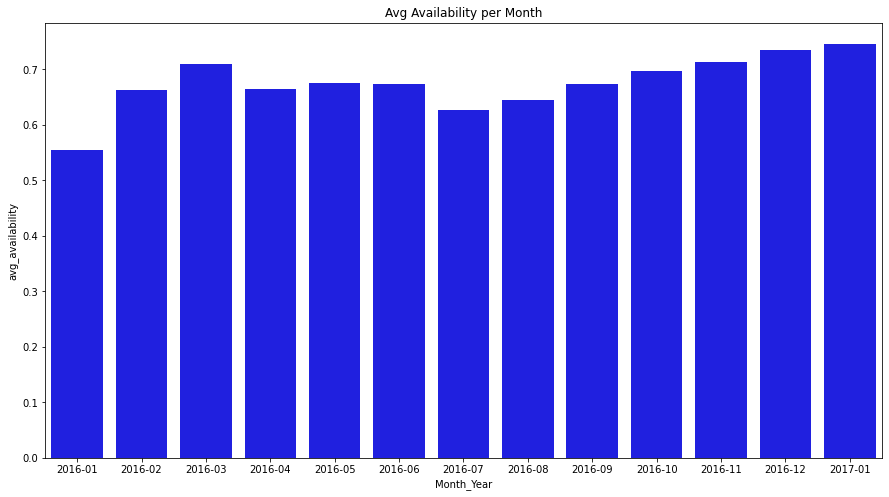

In [11]:
availibility=df_calendar.groupby('Month_Year')['available'].mean().reset_index().rename(columns={'available':'avg_availability'})

x=availibility['Month_Year']
y=availibility['avg_availability']

#availibility.plot()
plt.figure(figsize=(15,8))
plt.title("Avg Availability per Month")

sns.barplot(data=availibility,x='Month_Year',y='avg_availability',color='b',palette=None)
availibility.sort_values(by='avg_availability',ascending=False)

It Seems like the business was working well in that year specially in March, November, December and January. 
and this is totally making sense as most of the travellers usually go to seattle and europe in general near Christmas. at which you will enjou the weather and the ambience.
Also it seems like poeple love to visit Seattle at Spring as we see, in March it's quite busy.

2) when is the highest averageprice of listings per night ?

,Month_Year,avg_price
6,2016-07,152.094150
7,2016-08,150.656594
5,2016-06,147.473137
8,2016-09,143.255949
4,2016-05,139.538183
11,2016-12,137.251835
9,2016-10,137.031939
12,2017-01,136.882590
10,2016-11,135.688738
3,2016-04,135.097005


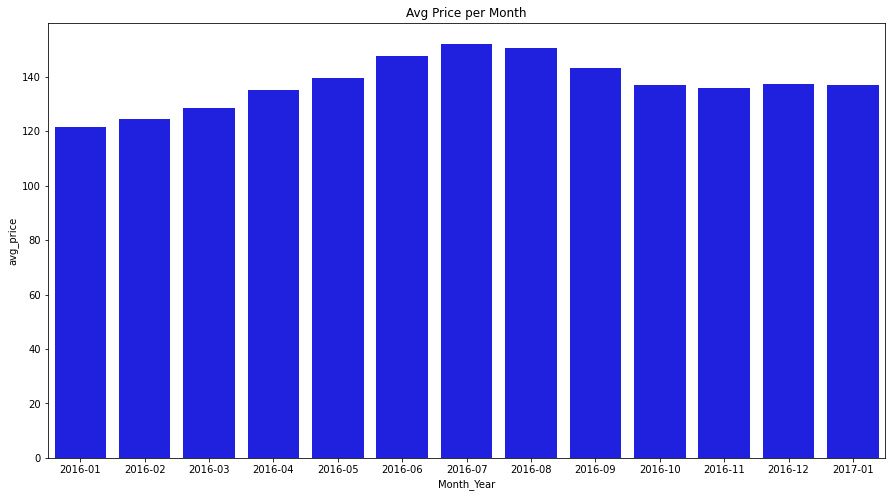

In [12]:
Avg_Prices=df_calendar.groupby('Month_Year')['price'].mean().reset_index().rename(columns={'price':'avg_price'})

x=Avg_Prices['Month_Year']
y=Avg_Prices['avg_price']

#availibility.plot()
plt.figure(figsize=(15,8))
plt.title("Avg Price per Month")
sns.barplot(data=Avg_Prices,x='Month_Year',y='avg_price',color='b',palette=None)
Avg_Prices.sort_values(by='avg_price',ascending=False)

As seen , the Highest Prices are in June, July and August, Summer time !. 
and this is matching what we saw in the availability chart as the lowest availability is at these months in particular.

3) Where are the most/less expensive listings ? at which neighbourhoods in Seattle

,neighbourhood,avg_price
0,Fairmount Park,370.000000
1,Industrial District,245.000000
2,Portage Bay,241.428571
3,Westlake,197.000000
4,Alki,196.652174


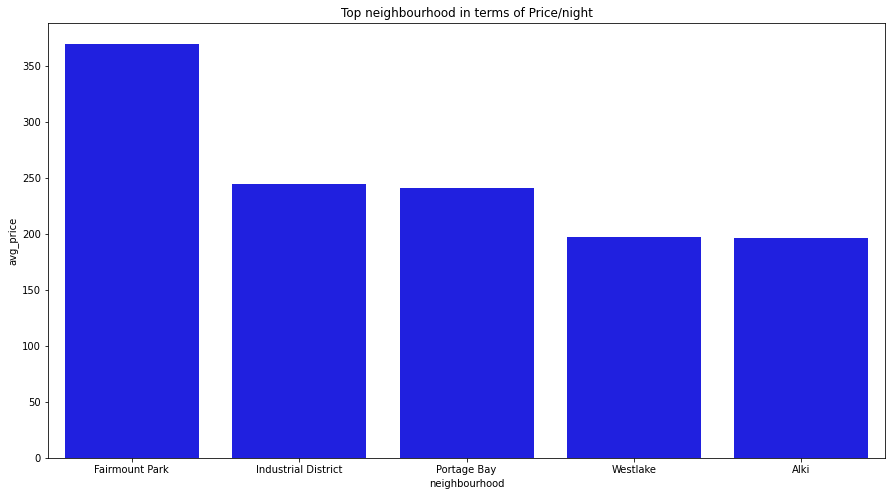

In [13]:
Top_neighbour_per_price=df_listing.groupby('neighbourhood')['price'].mean().sort_values(ascending=False).reset_index().rename(columns={'price':'avg_price'})

x=Top_neighbour_per_price['neighbourhood'].head(5)
y=Top_neighbour_per_price['avg_price'].head(5)

plt.figure(figsize=(15,8))
plt.title("Top neighbourhood in terms of Price/night")
sns.barplot(data=Top_neighbour_per_price,x=x,y=y,color='b',palette=None)
Top_neighbour_per_price.head(5)

So, the most expensive neighbourhood in seattle is Fairmount Park , this is due to its luxury,location and property amenties

let's check the cheapiest neighbourhood prices

,neighbourhood,avg_price
0,Roxhill,60.000000
1,Olympic Hills,63.666667
2,Dunlap,75.461538
3,Rainier Beach,76.722222
4,Georgetown,77.000000


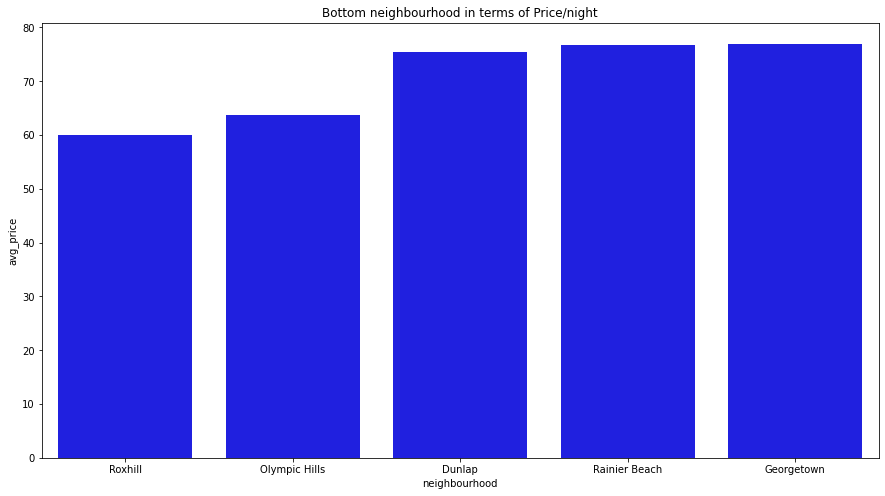

In [14]:
bottom_neighbour_per_price=df_listing.groupby('neighbourhood')['price'].mean().sort_values(ascending=True).reset_index().rename(columns={'price':'avg_price'})

x=bottom_neighbour_per_price['neighbourhood'].head(5)
y=bottom_neighbour_per_price['avg_price'].head(5)

plt.figure(figsize=(15,8))
plt.title("Bottom neighbourhood in terms of Price/night")
sns.barplot(data=bottom_neighbour_per_price,x=x,y=y,color='b',palette=None)
bottom_neighbour_per_price.head(5)

4) Who are the top host names and what are the types of listings they offer ?

In [15]:

df_listing.room_type.value_counts()


host_stats_total=df_listing.groupby('host_name')['id'].count().sort_values(ascending=False).reset_index().rename(columns={'id': 'total'})
host_stats_entire=df_listing[df_listing['room_type']=='Entire home/apt'].groupby('host_name')['id'].count().sort_values(ascending=False).reset_index().rename(columns={'id':'entire'})
host_stats_private=df_listing[df_listing['room_type']=='Private room'].groupby('host_name')['id'].count().sort_values(ascending=False).reset_index().rename(columns={'id': 'private'})
host_stats_shared=df_listing[df_listing['room_type']=='Shared room'].groupby('host_name')['id'].count().sort_values(ascending=False).reset_index().rename(columns={'id': 'shared'})

dfs=[host_stats_total, host_stats_entire,host_stats_shared,host_stats_private]
dfs=[df.set_index('host_name') for df in dfs]

top_5_hosts=dfs[0].join(dfs[1:]).fillna(0).head(5) 
top_5_hosts.rename(columns={'total':'Total_listings','entire': 'Entire Room','shared':'Shared Room','private':'Private Room'},inplace=True)
top_5_hosts

,Total_listings,Entire Room,Shared Room,Private Room
host_name,,,,
Andrew,56,10.0,36.0,10.0
Jordan,48,46.0,0.0,2.0
Daniela,47,47.0,0.0,0.0
Michael,46,17.0,14.0,15.0
Melissa,45,35.0,0.0,10.0


Now it's business, Hosts are using airbnb to build a business that seems to work well all over the year. 
so Andrew has 56 listings ready for booking and he has various type of properties. 

# Conclusion

The business is good all over the year but it's at the peak in March,November,December and January.However, the most expensive time to book is in June,July and August which accordingly accompanied by low available listings, this is to keep profit constant as much as hosts can. 
Also airbnb allowed people to build their business with help of airbnb platform, as we saw hosts with more than 50 listings in Seattle.

Last thing, if you want to get listing and enjoy luxurious visit, go to fairmount park neighbourhood, costy but worth it!. if you are not interested and you want the cheapest prices , go to roxhill or olympic hills but with less amenties properties.